# Receiver Function inversion: optimization and Bayesian sampling

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function_no_espresso.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In this notebook, we run inversion on a receiver function inversion problem with optimisation and sampling.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi pyrf96

In [2]:
# If this notebook is run locally pyrf96 needs to be installed separately by uncommenting the following lines, 
# that is by removing the # and the white space between it and the exclamation mark.
# !pip install pyrf96

In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import emcee
import multiprocessing

import cofi
import pyrf96

In [4]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

In [5]:
# display theory on receiver function
from IPython.display import display, Markdown

with open("../../theory/geo_receiver_function.md", "r") as f:
    content = f.read()

display(Markdown(content))

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

We refer you to the paper below for description of the algorithms and the forward kernel we use:

*Genetic algorithm inversion for receiver functions with application to crust and uppermost mantle structure beneath Eastern Australia*,
Shibutani, T., Kennett, B. and Sambridge, M., Geophys. Res. Lett., 23 , No. 4, 1829-1832, 1996.

In order to better understand the complexity and non-linear nature of seismic receiver function inversion, we have included a few illustrative animations. These animations highlight the substantial influence of velocities and, more prominently, interface depths on the resulting receiver functions.

![depth_layer3_anim4.gif](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/depth_layer3_anim4.gif?raw=true)

![vel_layer3_anim4_400f.gif](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/vel_layer3_anim4_400f.gif?raw=true)

This is a non-linear problem which can be highly sensitive to the starting model. 

![3Dsurf_x40y10_v55_l270_35](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/3Dsurf_x40y10_v55_l270_35.png?raw=true)


We are going to use the receiver function package in 
[`pyrf96`](https://github.com/inlab-geo/pyrf96),
with calls to Fortran routines developed by Prof. T. Shibutani in the backend.

The function `pyrf96.rfcalc()` computes synthetic receiver functions. It is called as follows:
```python
t,rfunc = pyrf96.rfcalc(model)
```
where `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of P-wave speed to S-wave speed. The maximum depth of discontinuity that can be considered is 60km.

For example, here is the Earth model.

In [6]:
good_model = np.array([[1,3.0,1.7],
                  [8.0,3.2,2.0],
                  [20, 4.0,1.7],
                  [45,4.2,1.7]])

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.
In this example, we fix the ratio of S-wave speed to P-wave speed, and treat the interface depths and velocities of 3 layers as unknowns.

Here we use the model to calculate the receiver function both with and without correlated noise added, with signal to noise parameter `sn=0.5`. (The noise here is added in the frequency domain, for details see Shibutani etal. (1996).)

In [7]:
# calculate and plot receiver function
t,rfunc = pyrf96.rfcalc(good_model)          # Receiver function
t2,rfunc_noise = pyrf96.rfcalc(good_model,sn=0.5,seed=12345678) # Receiver function with added correlated noise

If we had field data we wanted to invert we would load here and simply assign it to `t2` and `rfunc_noise` that is replace our synthetic data.

Now we plot the model and the receiver function together.

In [8]:
def plotRFmod(RFo,time1,model,RF2=None,model2=None,mlabels=None): # Receiver function and model plotting utility
    '''
    Plot RFmod
    
    Inputs:
        RF, numpy.ndarray(n,)        : Amplitude of receiver function
        time, numpy.ndarray(n,)      : Time points of receiver function
        model, numpy.ndarray(L,3)    : Velocity model as triplet of (depth,S-wavespeed,VpVs ratio) for L layers
    
    If RF2 is not None then it is assumed RF2=[RFp,time2] and a second RF is plotted.
    If model2 is not None then a second comparison model is plotted.
    '''    
    px = np.zeros([2*len(model),2])
    py = np.zeros([2*len(model),2])
    n=len(model)
    px[0::2,0],px[1::2,0],px[1::2,1],px[2::2,1] = model[:,1],model[:,1],model[:,0],model[:-1,0]

    if(mlabels is None):
        mlabels = ['Input model','Reference model']

    f, (a0, a1) = plt.subplots(1,2, figsize=(12,4), gridspec_kw = {'width_ratios':[1, 3]})

    a1.set_title('Velocity model and receiver functions')
    a1.set_xlabel("Time (s)")
    a1.set_ylabel("Amplitude")
    a1.grid(True)
    a1.plot(time1, RFo, 'r-',label='Observed')
    if(RF2 is not None):a1.plot(RF2[1], RF2[0], label='Predicted')
    a1.legend()

    a0.set_title(" Velocity model")                   # Plot velocity model with Receiver function
    a0.set_xlabel('Vs (km/s)')
    a0.set_ylabel('Depth (km)')
    a0.plot(px[:,0],px[:,1],'b-',label=mlabels[0])

    if(model2 is not None):
        px2 = np.zeros([2*len(model2),2])
        py2 = np.zeros([2*len(model2),2])
        n=len(model)
        px2[0::2,0],px2[1::2,0],px2[1::2,1],px2[2::2,1] = model2[:,1],model2[:,1],model2[:,0],model2[:-1,0]
        a0.plot(px2[:,0],px2[:,1],'k-',lw=0.5,label=mlabels[1])
        a0.legend()

    a0.invert_yaxis()

    #plt.tight_layout()
    plt.show()

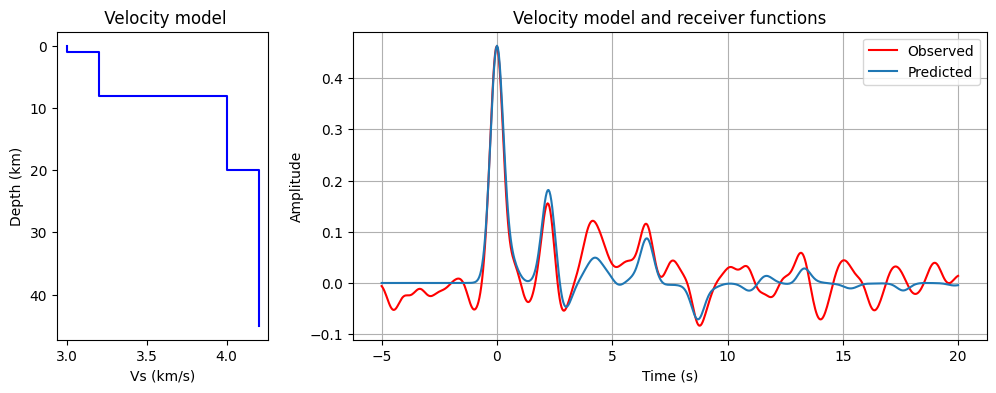

In [9]:
plotRFmod(rfunc_noise,t2,good_model,RF2=[rfunc,t])

## 1. Solve with an optimiser

### 1.1 Problem set up

Here we decide to only vary the layer velocities and interface depths only, and not the Vp/Vs ratio parameters in the Earth model. So we have to provide a subset of the model vector to the minimization routine. We define a simple conversion between the two with routines `get_inversion_parameters()` and its converse `get_model_parameters()`.

In [10]:
# conversion routines
vpvs = good_model[:,2] # fixed vpvs parameters
def get_inversion_parameters(fullmodel): # convert model to inversion parameters
    return fullmodel[:,:2].flatten() # remove last column and flatten
#
def get_model_parameters(invmodel): # convert inversion parameters to fullmodel
    return np.append(invmodel.reshape(len(vpvs),-1), vpvs[:,None],axis=1) # reshape and add last column

In preparation for optimisation we need to measure the fit of this *observed* receiver function to the receiver function predicted by any other model, ${\mathbf d}_{pred}$, we need to compute the negative log of the Likelihood

\begin{equation*}
-\log (p({\mathbf d}_{obs} | {\mathbf m}) = ({\mathbf d}_{obs}-{\mathbf d}_{pred})^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred})
\end{equation*}

where $C_D^{-1}$ is the inverse data covariance matrix describing correlated noise in the receiver function. You can do this using the supplied routine `rfcalc.InvDataCov` which takes arguments ($\sigma_t$,$\sigma_a$,$n$), and builds an $n\times n$ inverse data covariance matrix for a time signal with amplitude variance $\sigma_a^2$ and time correlation length $\sigma_t$, for receiver length of $n$ time samples. In this example you can use $\sigma_t = 2.5$, $\sigma_a=0.01$. 

In [11]:
observed_data = rfunc_noise                    # Define observed data
Cdinv = pyrf96.InvDataCov(2.5,0.01,len(rfunc)) # Define inverse data covaraince for the noisy receiver function

In [12]:
def my_misfit(imodel): # misfit function to be minimized
    model = get_model_parameters(imodel)       # recover full model from inversion parameters
    t,predicted_data = pyrf96.rfcalc(model)    # predicted data from model
    res = observed_data-predicted_data         # residual between observed and predicted data
    misfit_val = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0 # data misfit
    if math.isnan(misfit_val):
        return float("inf")
    return misfit_val

### 1.1 Define BaseProblem

In [13]:
my_problem = cofi.BaseProblem()

Here we set a starting model that is reasonably close to the true model, so that the optimisation converges.

In [14]:
initialmodel = np.array([[1.1,3.0,1.7],
                  [7.0,3.2,2.0],
                  [18, 4.1,1.7],
                  [40,4.2,1.7]])

In [15]:
# problem set up in cofi
my_problem.set_objective(my_misfit)
my_problem.set_initial_model(get_inversion_parameters(initialmodel))

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (8,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### 1.2 Define InversionOptions

In [16]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")   # Nelder-Mead or COBYLA

### 1.3 Define Inversion and run

In [17]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 419.7184672659848
nit: 382
nfev: 670
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[ 0.87187839,  3.00756611,  7.82215285,  3.0964248 , 19.61713707,
         3.93631238, 40.04903895,  4.3816799 ],
       [ 0.87187836,  3.00756612,  7.82215289,  3.09642482, 19.61713698,
         3.9363124 , 40.0490394 ,  4.3816799 ],
       [ 0.87187834,  3.00756612,  7.82215307,  3.09642483, 19.61713685,
         3.93631238, 40.04903936,  4.3816799 ],
       [ 0.87187833,  3.00756614,  7.822153  ,  3.09642483, 19.61713707,
         3.9363124 , 40.04903931,  4.38167987],
       [ 0.87187835,  3.00756611,  7.82215294,  3.09642484, 19.61713712,
         3.93631243, 40.04903949,  4.38167986],
       [ 0.87187818,  3.00756615,  7.82215343,  3.09642487, 19.61713687,
         3.93631248, 40.04904104,  4.38167989],
       [ 0.87187826,  3.00756615,  7.82215336,  3.09642483, 19.61713667,
         3.93631243,

In [18]:
my_result_model = get_model_parameters(my_result_optimiser.model)
print("Inversion result:    \n", my_result_model)
print("Reference good model:\n", good_model)

Inversion result:    
 [[ 0.87187839  3.00756611  1.7       ]
 [ 7.82215285  3.0964248   2.        ]
 [19.61713707  3.93631238  1.7       ]
 [40.04903895  4.3816799   1.7       ]]
Reference good model:
 [[ 1.   3.   1.7]
 [ 8.   3.2  2. ]
 [20.   4.   1.7]
 [45.   4.2  1.7]]


### 1.4 Plotting

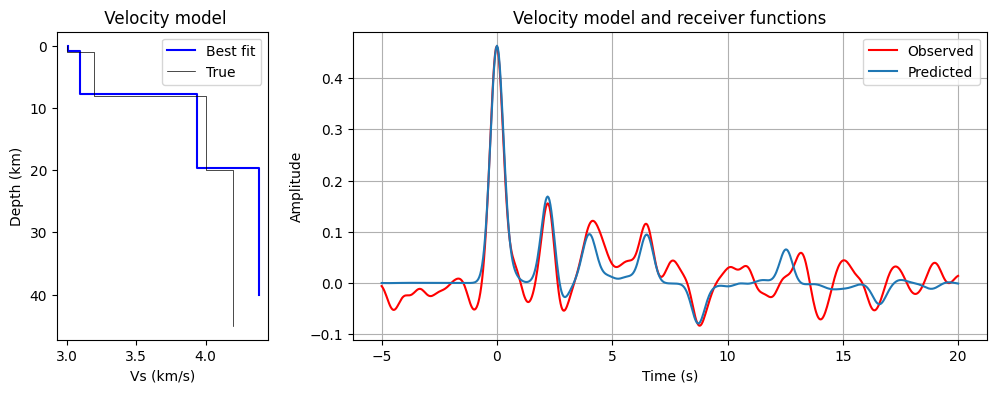

In [19]:
t,predicted_data = pyrf96.rfcalc(my_result_model)    # predicted data from model
plotRFmod(observed_data,t,my_result_model,RF2=[predicted_data,t],
          model2=good_model,mlabels=['Best fit','True'])

## 2. Bayesian sampling

### 2.1 Enrich BaseProblem

In preparation for sampling:

In [20]:
def my_log_likelihood(model): # log-likelihood of negative of our misfit
    return -my_misfit(model)

def my_log_prior(model): # define a uniform prior between bounds on interface depths and S-velocity

    real_model = get_model_parameters(model) # recover full model from inversion parameters 
    depths_in_0_60 = all([m_p < 60 and m_p > 0 for m_p in good_model[:,0]]) # are all interface depths between 0,60km? 
    veloc_in_range = all([m_p < 4.5 and m_p > 2 for m_p in good_model[:,1]]) # are all velocities depths between 2,4.5km/s?
    if depths_in_0_60 and veloc_in_range: # return log of prior normalization
        return (-np.log(60.)-np.log(2.5)).item()
    return float("-inf")

ndim = len(get_inversion_parameters(good_model))

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 8
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


In [21]:
nwalkers = 32
nsteps = 25000
walkers_start = my_result_optimiser.model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

### 2.2 Define InversionOptions, Inversion and run

In [22]:
import warnings
warnings.filterwarnings("ignore")

my_options_sampler = cofi.InversionOptions()
my_options_sampler.set_tool("emcee")
my_options_sampler.set_params(
    nwalkers=nwalkers,
    nsteps=nsteps,
    initial_state=walkers_start,
    progress=True,
)
inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
inv_result_sampler = inv_sampler.run()

100%|██████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [03:09<00:00, 131.99it/s]


In [23]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### 2.3 Plotting

In [24]:
var_names = [
    "depth1 (km)", 
    "velocity1 (km/s)", 
    "depth2 (km)", 
    "velocity2 (km/s)", 
    "depth3 (km)", 
    "velocity3 (km/s)", 
    "depth4 (km)", 
    "velocity4 (km/s)", 
]
true_model = get_inversion_parameters(good_model)
var_lines = [(var_names[i],{}, true_model[i]) for i in range(len(var_names))]
az_inf_data = inv_result_sampler.to_arviz(var_names=var_names)
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

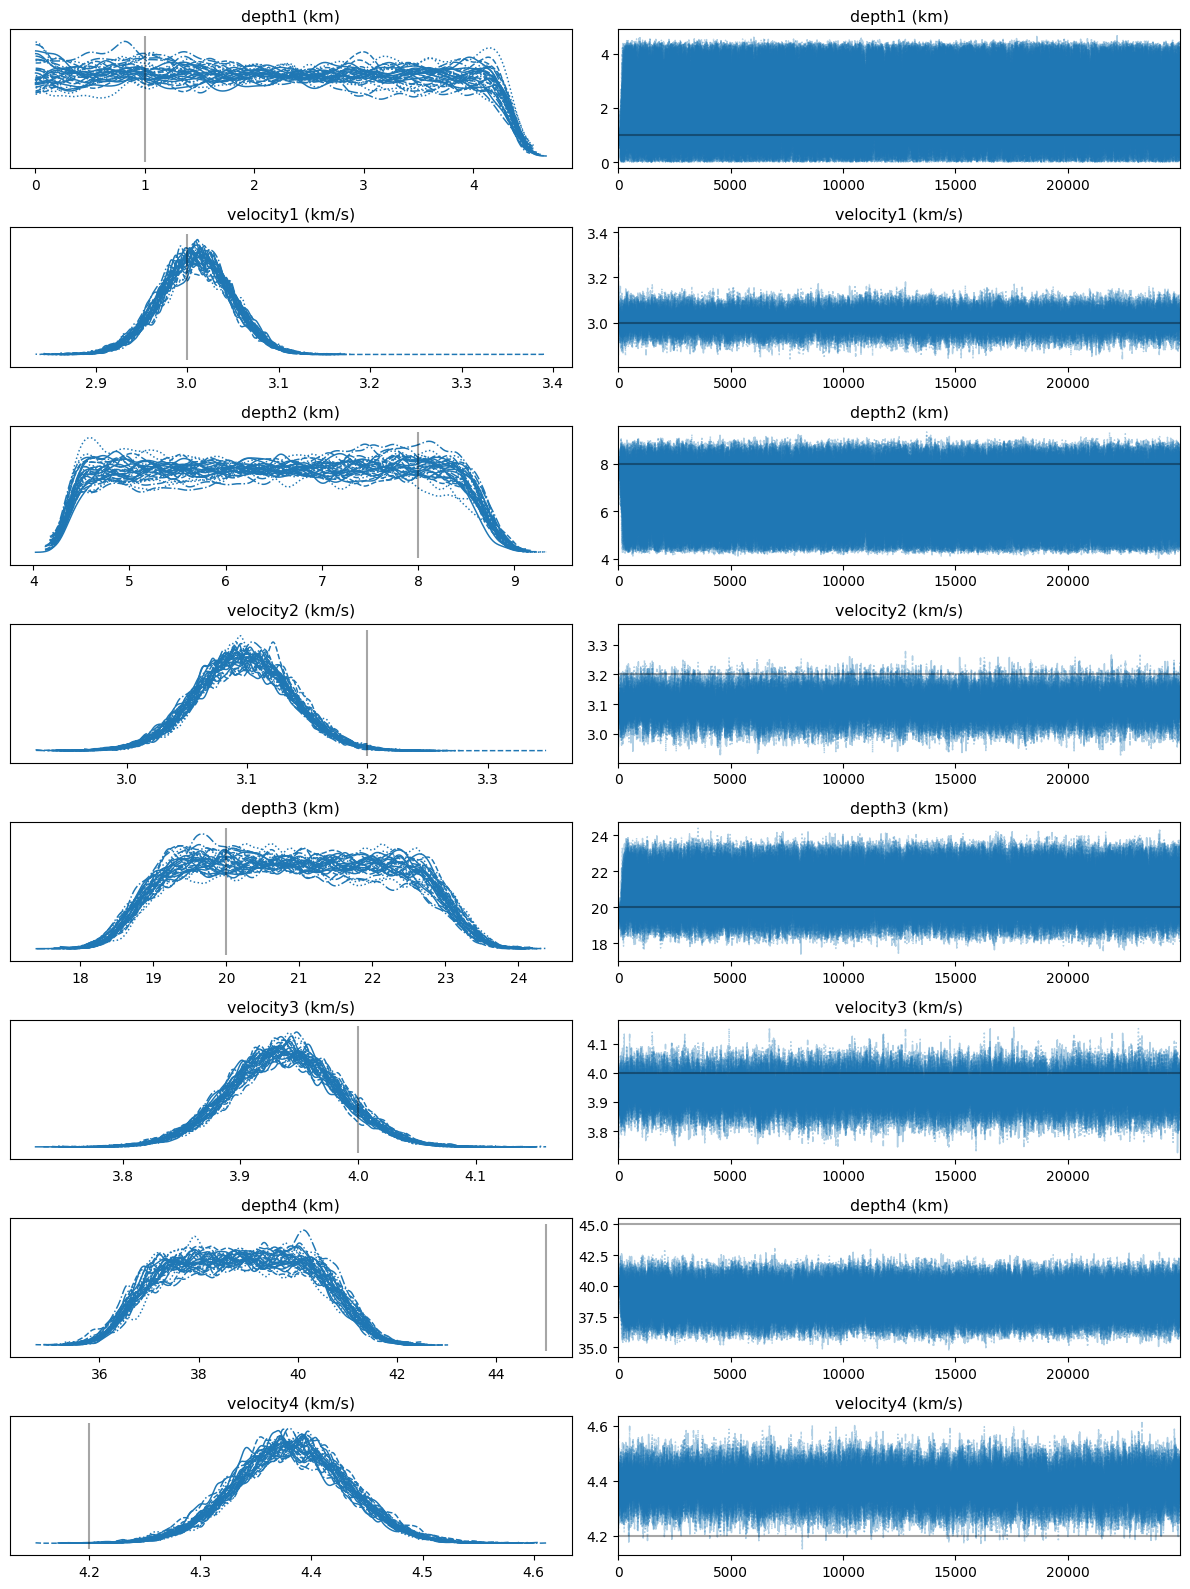

In [25]:
arviz.plot_trace(az_inf_data, var_names=var_names,lines=var_lines);
plt.tight_layout();

The walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details). Usually for reliability we want the length of the chains to be greater that fifty times the largest autocorrelation time of any parameter.

In [26]:
tau = inv_result_sampler.sampler.get_autocorr_time()
print(f"autocorrelation times for each parameter:\n {tau}")
tau_ok = all([tcorr < 50*nsteps for tcorr in tau]) # were the chains long enough?
if(tau_ok): 
    print("All autocorrelation times OK")
else:
    print("Autocorrelation unreliable. Increase length of chains and rerun")

autocorrelation times for each parameter:
 [120.18654257 111.04747363 119.74250976 104.99593578 117.80099583
 108.29900611 119.76255759 108.45636428]
All autocorrelation times OK


Let’s discard the initial 500 steps and make a corner plot:

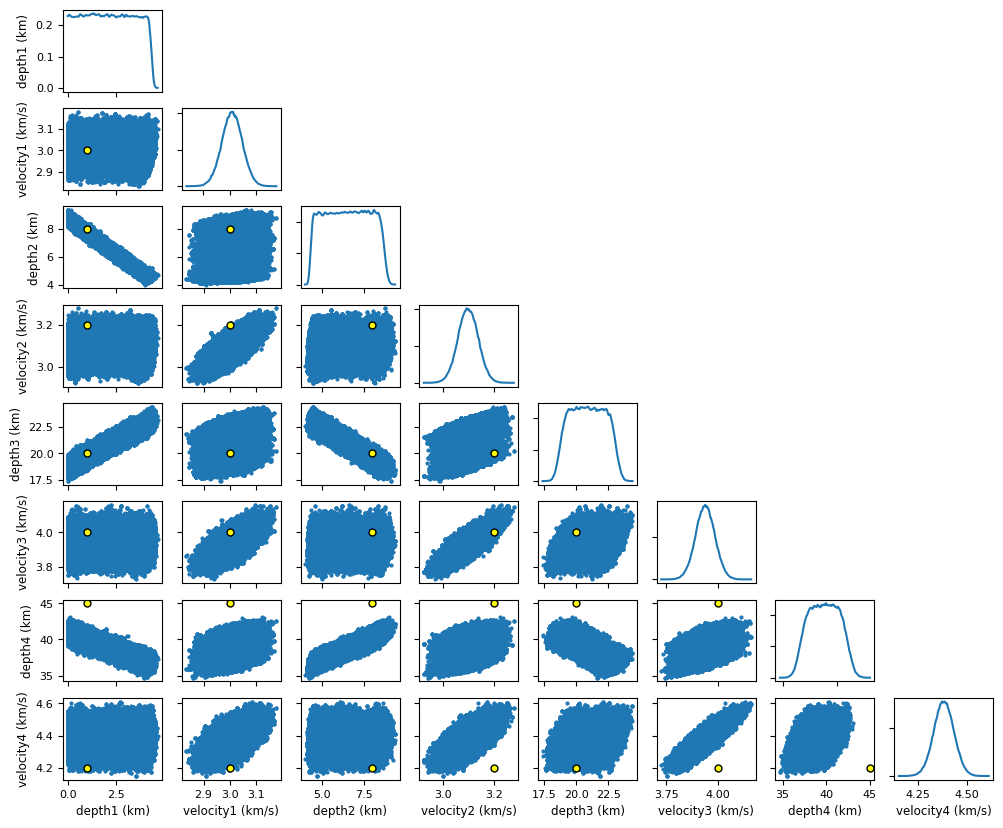

In [27]:
az_inf_data_after_500 = az_inf_data.sel(draw=slice(300,None))

true_values = {
    f"{var_names[i]}": true_model[i] for i in range(true_model.size)
}

fig, axes = plt.subplots(8, 8, figsize=(12, 10))
_ = arviz.plot_pair(
    az_inf_data_after_500,
    marginals=True,
    ax=axes,
    textsize=8,
)

for i, j in np.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=5, markeredgecolor="k")

plt.show()


Now examine the mean model of the posterior ensemble.

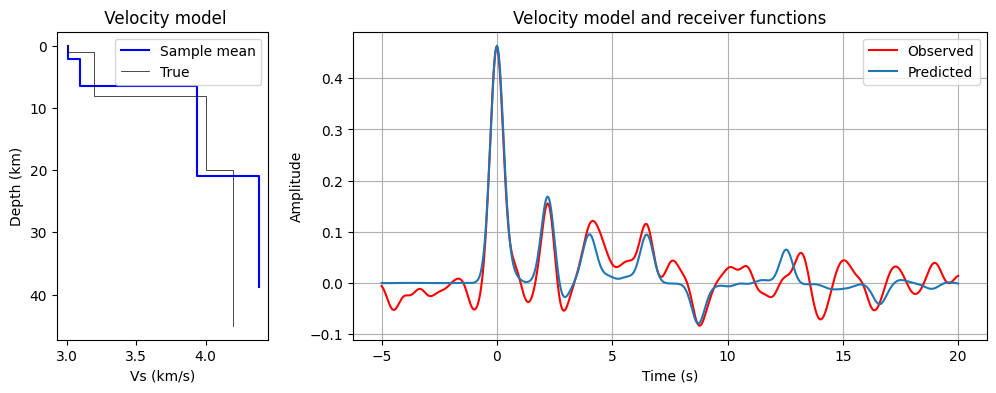

Mean of samples:
      [ 2.158565    3.00944696  6.54444552  3.09725917 20.90669543  3.93766698
 38.8180801   4.38201063]
Reference good model:
 [ 1.   3.   8.   3.2 20.   4.  45.   4.2]


In [28]:
mean_sample = np.array(az_inf_data["posterior"][var_names].mean().to_array())
median_sample = np.array(az_inf_data["posterior"][var_names].median().to_array())

my_mean_model = get_model_parameters(mean_sample)

t,mean_sample_predicted_rf = pyrf96.rfcalc(my_mean_model)          # Receiver function

plotRFmod(observed_data,t,my_mean_model,RF2=[mean_sample_predicted_rf,t],
          model2=good_model,mlabels=['Sample mean','True'])

print("Mean of samples:\n     ", mean_sample)
print("Reference good model:\n", true_model)

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [29]:
watermark_list = ["cofi", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10
numpy 2.1.3
matplotlib 3.10.1
emcee 3.1.6
arviz 0.20.0
